# Bregman Douglas Rachford Splitting Example

## Import the required libraries

In [1]:
import pepflow as pf
import numpy as np
import sympy as sp
import matplotlib.pyplot as plt

## Define the functions

In [2]:
L = pf.Parameter("L")
mu = pf.Parameter("mu")
f = pf.SmoothConvexFunction(is_basis=True, tags=["f"], L=L)
g = pf.SmoothConvexFunction(is_basis=True, tags=["g"], L=L)
F = f + g
h = pf.SmoothStronglyConvexFunction(is_basis=True, tags=["h"], L=L, mu=mu)

## Write a function to return the PEPContext associated with Bregman Proximal Point Method

In [3]:
def make_ctx_bdrs(
    ctx_name: str, N: int | sp.Integer, stepsize: pf.Parameter
) -> pf.PEPContext:
    ctx_bdrs = pf.PEPContext(ctx_name).set_as_current()
    # Declare the initial points.
    x = pf.Vector(is_basis=True, tags=["x_0"])
    F.set_stationary_point("x_star")
    for i in range(N):
        w = f.bregman_proximal_step(x, stepsize, h)
        w.add_tag(f"w_{i}")
        x_bar = pf.Vector(is_basis=True, tags=[f"x_bar_{i}"])
        h.add_point_with_grad_restriction(x_bar, h.grad(w) - stepsize * f.grad(w))
        z = g.bregman_proximal_step(x_bar, stepsize, h)
        z.add_tag(f"z_{i}")
        y = pf.Vector(is_basis=True, tags=[f"y_{i}"])
        h.add_point_with_grad_restriction(y, h.grad(z) - stepsize * g.grad(z))
        x = pf.Vector(is_basis=True, tags=[f"x_{i + 1}"])
        h.add_point_with_grad_restriction(
            x, 0.5 * h.grad(ctx_bdrs[f"x_{i}"]) + 0.5 * h.grad(y)
        )
    return ctx_bdrs

## Numerical evidence of convergence of BDRS

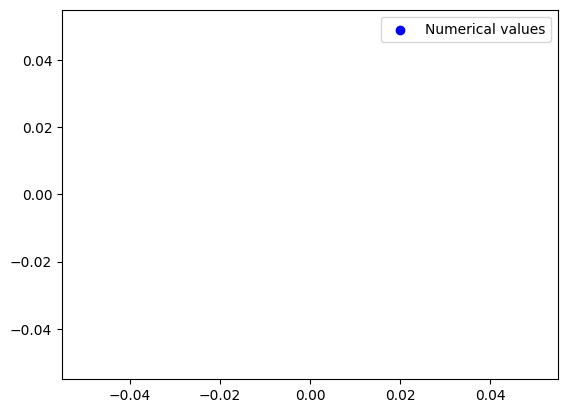

In [4]:
N = 2
alpha = pf.Parameter("alpha")
R = pf.Parameter("R")
alpha_value = 1
R_value = 1
L_value = 1
mu_value = 0.5

ctx_plt = make_ctx_bdrs(ctx_name="ctx_plt", N=N, stepsize=alpha)

x_0 = ctx_plt["x_0"]
x_star = ctx_plt["x_star"]

pb_plt = pf.PEPBuilder(ctx_plt)
pb_plt.add_initial_constraint(
    (h(x_star) - h(x_0) - h.grad(x_0) * (x_star - x_0)).le(R, name="initial_condition")
)

opt_values = []
for k in range(1, N):
    x_k = ctx_plt[f"x_{k}"]
    pb_plt.set_performance_metric(F(x_k) - F(x_star))
    result = pb_plt.solve(
        resolve_parameters={
            "alpha": alpha_value,
            "R": R_value,
            "L": L_value,
            "mu": mu_value,
        }
    )
    opt_values.append(result.opt_value)

iters = np.arange(1, N)
# cont_iters = np.arange(1, N, 0.01)
# plt.plot(
#     cont_iters,
#     L_value / (4 * cont_iters),
#     "r-",
#     label="Analytical bound $\\frac{L}{4k}$",
# )
plt.scatter(iters, opt_values, color="blue", marker="o", label="Numerical values")
plt.legend()

In [5]:
print(opt_values)

[inf]
